In [57]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
from datetime import date
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# no warnings
import warnings
warnings.filterwarnings('ignore')

In [58]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "priceRange"

In [59]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [60]:
classes = train[label].unique().tolist()
print(f"Label classes: {classes}")

train[label] = train[label].map(classes.index)

Label classes: ['650000+', '350000-450000', '0-250000', '450000-650000', '250000-350000']


In [61]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [62]:
test.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms'],
      dtype='object')

# Train

In [63]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [64]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    
    # lower case
    dataset['description'] = dataset['description'].str.lower()
    
    #remove punctuations
    train["description"] = train['description'].str.replace('[^\w\s]','')
    
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [65]:
train

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,multiple offers submit best final to agent by...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.000000,17,4.0,4,0
1,13380,austin,4644 hoffman dr austin tx 78749 is a single fa...,Single Family,30.199486,-97.859947,0,False,1997,0,6534.0,6.666667,16,3.0,4,1
2,4115,austin,6804 canal st austin tx 78741 is a single fami...,Single Family,30.227398,-97.696083,0,False,1952,0,5619.0,3.333333,11,1.0,2,2
3,6926,austin,beautiful large lot with established trees lov...,Single Family,30.205469,-97.792351,4,False,1976,0,6416.0,4.000000,14,2.0,4,2
4,14480,austin,stunning nw hills designer remodel by cedar an...,Single Family,30.345106,-97.767426,2,False,1984,0,10759.0,7.000000,16,3.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8614,austin,updated great hills opportunity large corner l...,Single Family,30.409927,-97.763390,2,False,1982,3,15246.0,7.000000,17,3.0,3,0
9996,10505,austin,adorable 32 in the heart of south austin situa...,Single Family,30.206074,-97.779472,0,False,1970,0,6577.0,4.000000,14,2.0,3,4
9997,6942,austin,7322 gaines mill ln austin tx 78745 is a singl...,Single Family,30.198936,-97.810913,0,False,1981,1,7623.0,4.000000,13,2.0,3,1
9998,1845,austin,5213 doe valley ln austin tx 78759 is a single...,Single Family,30.391880,-97.761292,0,False,1979,2,13939.2,7.000000,17,3.0,3,4


In [66]:
def computation_transforms(dataset):
    """ 
    New Feature Engineering. Default, None...
    """
    dataset['hasSpa'] = np.where(dataset['hasSpa'] == True, 1, 0)
    return dataset

train = computation_transforms(train)
test = computation_transforms(test)

# Train

In [67]:
train.head(1)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,multiple offers submit best final to agent by...,Single Family,30.380089,-97.800621,0,0,1988,0,102366.0,7.0,17,4.0,4,0


In [68]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [69]:
train.shape

(10000, 16)

In [70]:
to_drop = ['uid','description','city','MedianStudentsPerTeacher','yearBuilt']
train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

In [71]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=label)
test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=label)
predictions = tfdf.keras.pd_dataframe_to_tf_dataset(test)

In [72]:
# A more complex, but possibly, more accurate model.
models = {
    'rf_baselines': tfdf.keras.RandomForestModel(),
    'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1"),
    'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(),
    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    }

evaluation = {}
for key in models:
    print(key)
    #Evaluate: metric logsloss: BinaryCrossentropy
    models[key].compile(metrics=["accuracy"])
    
    #with sys_pipes():
    models[key].fit(x=train_tf)
    evaluation[key] = models[key].evaluate(test_tf, return_dict=True)

rf_baselines
32/32 [==============================] - 1s 19ms/step - loss: 0.0000e+00 - accuracy: 0.6235
rf_tune1
32/32 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.6215
gbt_baselines
32/32 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.6170
gbt_tune1
32/32 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.6205


In [73]:
evaluation

{'rf_baselines': {'loss': 0.0, 'accuracy': 0.6234999895095825},
 'rf_tune1': {'loss': 0.0, 'accuracy': 0.6215000152587891},
 'gbt_baselines': {'loss': 0.0, 'accuracy': 0.6169999837875366},
 'gbt_tune1': {'loss': 0.0, 'accuracy': 0.6205000281333923}}

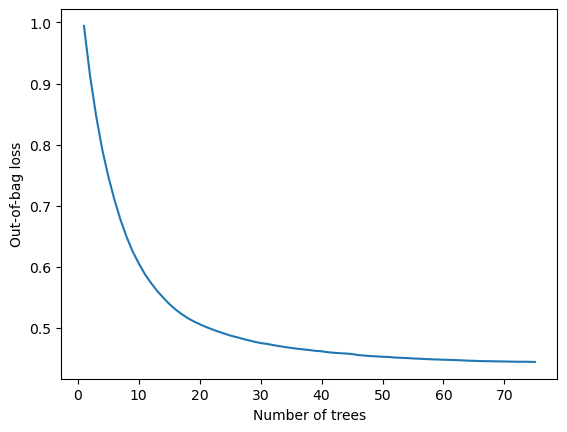

In [27]:
import matplotlib.pyplot as plt

logs = models['gbt_tune1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

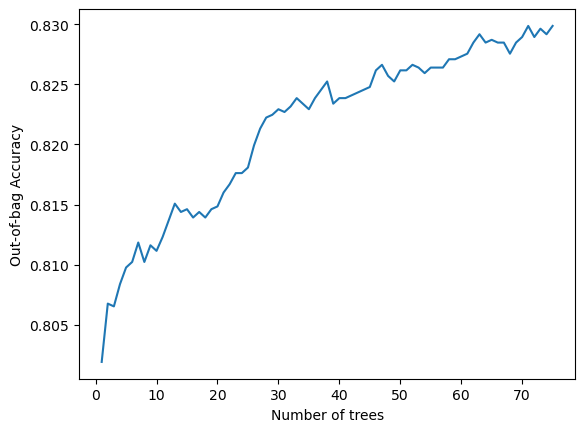

In [28]:
import matplotlib.pyplot as plt

logs = models['gbt_tune1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag Accuracy")
plt.show()

# Train on Entire Dataset


In [302]:
train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
# A more complex, but possibly, more accurate model.
models = {
    #'rf_baselines': tfdf.keras.RandomForestModel(),
    #'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION),
    #'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION),
    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    }

models['gbt_tune1'].compile(metrics=["accuracy"])
models['gbt_tune1'].fit(x=train_tf)

851/851 [==============================] - 1s 1ms/step


# Predictions

In [303]:
models

{'gbt_tune1': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7fe71c57cc40>}

In [304]:
scores = models['gbt_tune1'].predict(predictions)

In [305]:
#Label classes: ['adoption', 'no outcome', 'transfer']

In [306]:
scores

array([[8.7180000e-04, 9.9736279e-01, 1.7653710e-03],
       [2.0946354e-02, 7.1948725e-01, 2.5956640e-01],
       [9.3595344e-01, 3.3668408e-03, 6.0679663e-02],
       ...,
       [3.3661008e-01, 3.5512988e-02, 6.2787688e-01],
       [9.6797407e-01, 6.9470480e-03, 2.5078943e-02],
       [1.5179572e-01, 8.3186381e-02, 7.6501787e-01]], dtype=float32)

In [307]:
temp = pd.DataFrame(data=scores, columns=["adoption", "no outcome","transfer"])

In [308]:
temp['id'] = submission.id

In [309]:
temp = temp[['id','adoption','no outcome','transfer']]

In [310]:
temp

,id,adoption,no outcome,transfer
0,67473,0.000872,0.997363,0.001765
1,4629,0.020946,0.719487,0.259566
2,13914,0.935953,0.003367,0.060680
3,53131,0.093944,0.219680,0.686376
4,57800,0.585817,0.039921,0.374262
...,...,...,...,...
23312,9347,0.903591,0.038790,0.057620
23313,3781,0.004891,0.022325,0.972784
23314,74693,0.336610,0.035513,0.627877
23315,44987,0.967974,0.006947,0.025079


In [311]:
temp['no outcome'] = np.where(temp['no outcome'] > .96, 1, temp['no outcome'])
temp['adoption'] = np.where(temp['no outcome'] == 1, 0, temp['adoption'])
temp['transfer'] = np.where(temp['no outcome'] == 1, 0, temp['transfer'])

In [312]:
temp['adoption'] = np.where(temp['adoption'] > .96, 1, temp['adoption'])
temp['no outcome'] = np.where(temp['adoption'] == 1, 0, temp['no outcome'])
temp['transfer'] = np.where(temp['adoption'] == 1, 0, temp['transfer'])

In [313]:
temp['transfer'] = np.where(temp['transfer'] > .96, 1, temp['transfer'])
temp['adoption'] = np.where(temp['transfer'] == 1, 0, temp['adoption'])
temp['no outcome'] = np.where(temp['transfer'] == 1, 0, temp['no outcome'])

In [314]:
temp.to_csv('submission.csv', index=False)

In [316]:
!kaggle competitions submit -c sliced-s01e10-playoffs-2 -f submission.csv -m "Best With Names with outcome updates"

100%|█████████████████████████████████████████| 779k/779k [00:00<00:00, 850kB/s]
400 - Bad Request
